In [1]:
# Import the required libraries.
import os
import cv2
import math
import random
import numpy as np
import datetime as dt
import tensorflow as tf
import seaborn as sn
from collections import deque
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

%matplotlib inline

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import save_model
from tensorflow.keras.models import load_model


In [2]:
seed_constant = 27
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

In [ ]:
# Discard the output of this cell.
%%capture

# Downlaod the UCF50 Dataset
!wget --no-check-certificate https://www.crcv.ucf.edu/data/UCF50.rar

#Extract the Dataset
!unrar x UCF50.rar

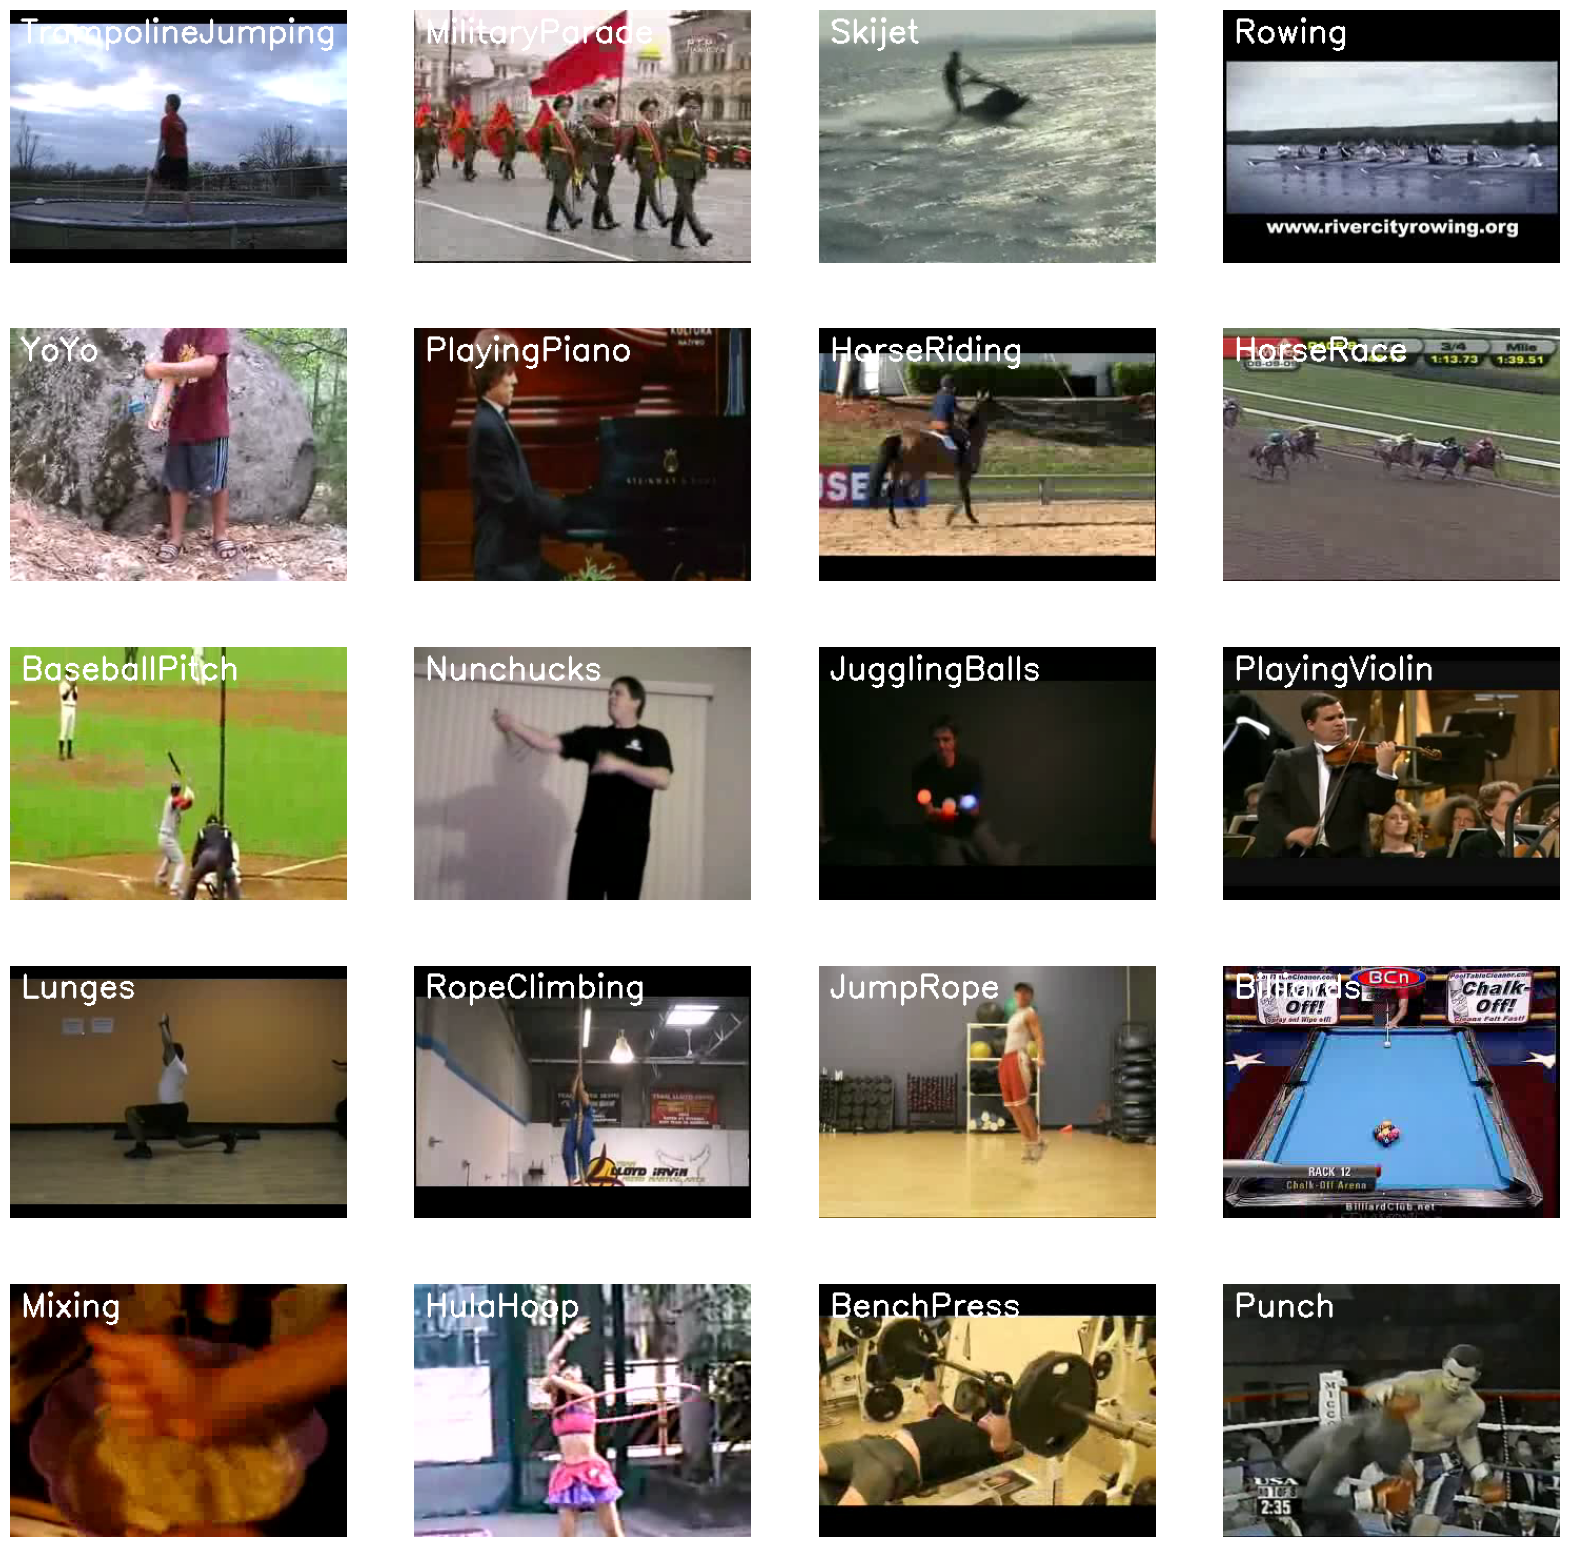

In [8]:
# Create a Matplotlib figure and specify the size of the figure.
plt.figure(figsize = (20, 20))

# Get the names of all classes/categories in model/UCF50.
all_classes_names = os.listdir('model/UCF50')

# Generate a list of 20 random values. The values will be between 0-50,
# where 50 is the total number of class in the dataset.
random_range = random.sample(range(len(all_classes_names)), 20)

# Iterating through all the generated random values.
for counter, random_index in enumerate(random_range, 1):

    # Retrieve a Class Name using the Random Index.
    selected_class_Name = all_classes_names[random_index]

    # Retrieve the list of all the video files present in the randomly selected Class Directory.
    video_files_names_list = os.listdir(f'model/UCF50/{selected_class_Name}')

    # Randomly select a video file from the list retrieved from the randomly selected Class Directory.
    selected_video_file_name = random.choice(video_files_names_list)

    # Initialize a VideoCapture object to read from the video File.
    video_reader = cv2.VideoCapture(f'model/UCF50/{selected_class_Name}/{selected_video_file_name}')

    # Read the first frame of the video file.
    _, bgr_frame = video_reader.read()

    # Release the VideoCapture object.
    video_reader.release()

    # Convert the frame from BGR into RGB format.
    rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)

    # Write the class name on the video frame.
    cv2.putText(rgb_frame, selected_class_Name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

    # Display the frame.
    plt.subplot(5, 4, counter);plt.imshow(rgb_frame);plt.axis('off')

In [44]:
all_classes_names[15:]

['GolfSwing',
 'Lunges',
 'PommelHorse',
 'BreastStroke',
 'PlayingPiano',
 'PlayingTabla',
 'Basketball',
 'VolleyballSpiking',
 'SoccerJuggling',
 'CleanAndJerk',
 'YoYo',
 'PushUps',
 'Kayaking',
 'HulaHoop',
 'JugglingBalls',
 'PlayingGuitar',
 'Fencing',
 'ThrowDiscus',
 'MilitaryParade',
 'RopeClimbing',
 'Biking',
 'Punch',
 'Drumming',
 'BenchPress',
 'Diving',
 'SalsaSpin',
 'PizzaTossing',
 'TaiChi',
 'HighJump',
 'JavelinThrow',
 'TrampolineJumping',
 'Skiing',
 'PlayingViolin',
 'HorseRace',
 'RockClimbingIndoor']

In [50]:
# Specify the height and width to which each video frame will be resized in our dataset.
IMAGE_HEIGHT , IMAGE_WIDTH = 64, 64

# Specify the number of frames of a video that will be fed to the model as one sequence.
SEQUENCE_LENGTH = 20

# Specify the directory containing the UCF50 dataset.
DATASET_DIR = "model/UCF50"

# Specify the list containing the names of the classes used for training. Feel free to choose any set of classes.
CLASSES_LIST = ["WalkingWithDog", "TaiChi", "Swing", "HorseRace","Basketball","Rowing","Skiing","PlayingViolin","PullUps","Diving","Biking","BenchPress"]

In [10]:
def frames_extraction(video_path):
    '''
    This function will extract the required frames from a video after resizing and normalizing them.
    Args:
        video_path: The path of the video in the disk, whose frames are to be extracted.
    Returns:
        frames_list: A list containing the resized and normalized frames of the video.
    '''

    # Declare a list to store video frames.
    frames_list = []

    # Read the Video File using the VideoCapture object.
    video_reader = cv2.VideoCapture(video_path)

    # Get the total number of frames in the video.
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

    # Calculate the the interval after which frames will be added to the list.
    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH), 1)

    # Iterate through the Video Frames.
    for frame_counter in range(SEQUENCE_LENGTH):

        # Set the current frame position of the video.
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)

        # Reading the frame from the video.
        success, frame = video_reader.read()

        # Check if Video frame is not successfully read then break the loop
        if not success:
            break

        # Resize the Frame to fixed height and width.
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))

        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1
        normalized_frame = resized_frame / 255

        # Append the normalized frame into the frames list
        frames_list.append(normalized_frame)

    # Release the VideoCapture object.
    video_reader.release()

    # Return the frames list.
    return frames_list

In [11]:
def create_dataset():
    '''
    This function will extract the data of the selected classes and create the required dataset.
    Returns:
        features:          A list containing the extracted frames of the videos.
        labels:            A list containing the indexes of the classes associated with the videos.
        video_files_paths: A list containing the paths of the videos in the disk.
    '''

    # Declared Empty Lists to store the features, labels and video file path values.
    features = []
    labels = []
    video_files_paths = []

    # Iterating through all the classes mentioned in the classes list
    for class_index, class_name in enumerate(CLASSES_LIST):

        # Display the name of the class whose data is being extracted.
        print(f'Extracting Data of Class: {class_name}')

        # Get the list of video files present in the specific class name directory.
        files_list = os.listdir(os.path.join(DATASET_DIR, class_name))

        # Iterate through all the files present in the files list.
        for file_name in files_list:

            # Get the complete video path.
            video_file_path = os.path.join(DATASET_DIR, class_name, file_name)

            # Extract the frames of the video file.
            frames = frames_extraction(video_file_path)

            # Check if the extracted frames are equal to the SEQUENCE_LENGTH specified above.
            # So ignore the vides having frames less than the SEQUENCE_LENGTH.
            if len(frames) == SEQUENCE_LENGTH:

                # Append the data to their repective lists.
                features.append(frames)
                labels.append(class_index)
                video_files_paths.append(video_file_path)

    # Converting the list to numpy arrays
    features = np.asarray(features)
    labels = np.array(labels)

    # Return the frames, class index, and video file path.
    return features, labels, video_files_paths

In [51]:
# Create the dataset.
features, labels, video_files_paths = create_dataset()

Extracting Data of Class: WalkingWithDog
Extracting Data of Class: TaiChi
Extracting Data of Class: Swing
Extracting Data of Class: HorseRace
Extracting Data of Class: Basketball
Extracting Data of Class: Rowing
Extracting Data of Class: Skiing
Extracting Data of Class: PlayingViolin
Extracting Data of Class: PullUps
Extracting Data of Class: Diving
Extracting Data of Class: Biking
Extracting Data of Class: BenchPress


In [52]:
# Using Keras's to_categorical method to convert labels into one-hot-encoded vectors
one_hot_encoded_labels = to_categorical(labels)

In [53]:
# Split the Data into Train ( 75% ) and Test Set ( 25% ).
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels,
                                                                            test_size = 0.25, shuffle = True,
                                                                            random_state = seed_constant)

np.save('data/features_train.npy', features_train)
np.save('data/features_test.npy', features_test)
np.save('data/labels_train.npy', labels_train)
np.save('data/labels_test.npy', labels_test)

In [54]:
features_train = np.load('data/features_train.npy')
features_test = np.load('data/features_test.npy')
labels_train = np.load('data/labels_train.npy')
labels_test = np.load('data/labels_test.npy')

In [ ]:
def create_convlstm_model():
    '''
    This function will construct the required convlstm model.
    Returns:
        model: It is the required constructed convlstm model.
    '''

    # We will use a Sequential model for model construction
    model = Sequential()

    # Define the Model Architecture.
    ########################################################################################################################

    model.add(ConvLSTM2D(filters = 4, kernel_size = (3, 3), activation = 'tanh',data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True, input_shape = (SEQUENCE_LENGTH,
                                                                                      IMAGE_HEIGHT, IMAGE_WIDTH, 3)))

    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))

    model.add(ConvLSTM2D(filters = 8, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))

    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))

    model.add(ConvLSTM2D(filters = 14, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))

    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))

    model.add(ConvLSTM2D(filters = 16, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))

    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    #model.add(TimeDistributed(Dropout(0.2)))



    model.add(Flatten())

    model.add(Dense(len(CLASSES_LIST), activation = "softmax"))

    ########################################################################################################################

    # Display the models summary.
    model.summary()

    # Return the constructed convlstm model.
    return model

In [ ]:
# Construct the required convlstm model.
convlstm_model = create_convlstm_model()

# Display the success message.
print("Model Created Successfully!")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d (ConvLSTM2D)    (None, 20, 62, 62, 4)     1024      
                                                                 
 max_pooling3d (MaxPooling3D  (None, 20, 31, 31, 4)    0         
 )                                                               
                                                                 
 time_distributed (TimeDistr  (None, 20, 31, 31, 4)    0         
 ibuted)                                                         
                                                                 
 conv_lstm2d_1 (ConvLSTM2D)  (None, 20, 29, 29, 8)     3488      
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 20, 15, 15, 8)    0         
 3D)                                                             
                                                        

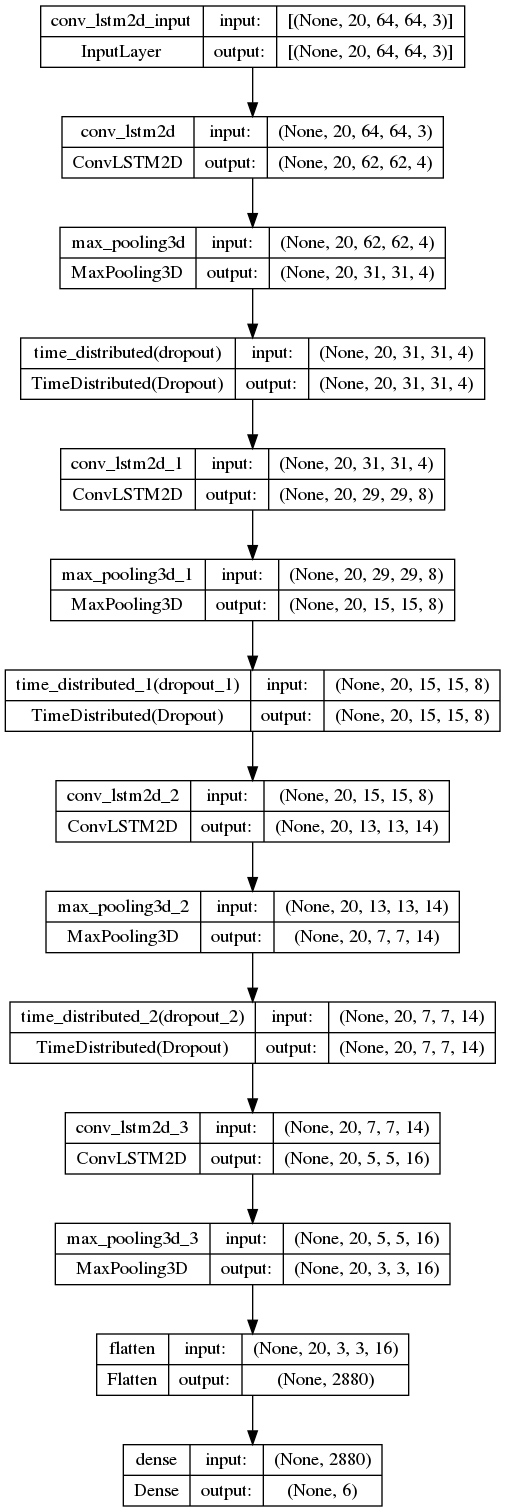

In [ ]:
# Plot the structure of the contructed model.
plot_model(convlstm_model, to_file = 'convlstm_model_structure_plot.png', show_shapes = True, show_layer_names = True)

In [ ]:
# Create an Instance of Early Stopping Callback
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 10, mode = 'min', restore_best_weights = True)

# Compile the model and specify loss function, optimizer and metrics values to the model
convlstm_model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])

# Start training the model.
convlstm_model_training_history = convlstm_model.fit(x = features_train, y = labels_train, epochs =70 , batch_size = 4,shuffle = True, validation_split = 0.2, callbacks = [early_stopping_callback])

Epoch 1/70
114/114 [==============================] - 234s 2s/step - loss: 1.7875 - accuracy: 0.2171 - val_loss: 1.7853 - val_accuracy: 0.1754
Epoch 2/70
114/114 [==============================] - 219s 2s/step - loss: 1.7018 - accuracy: 0.2917 - val_loss: 1.5943 - val_accuracy: 0.3421
Epoch 3/70
114/114 [==============================] - 220s 2s/step - loss: 1.5040 - accuracy: 0.3991 - val_loss: 1.4735 - val_accuracy: 0.4123
Epoch 4/70
114/114 [==============================] - 219s 2s/step - loss: 1.2385 - accuracy: 0.5197 - val_loss: 1.1545 - val_accuracy: 0.5965
Epoch 5/70
114/114 [==============================] - 221s 2s/step - loss: 0.9397 - accuracy: 0.6623 - val_loss: 0.9853 - val_accuracy: 0.6842
Epoch 6/70
114/114 [==============================] - 220s 2s/step - loss: 0.7180 - accuracy: 0.7390 - val_loss: 1.6928 - val_accuracy: 0.4561
Epoch 7/70
114/114 [==============================] - 222s 2s/step - loss: 0.6765 - accuracy: 0.7632 - val_loss: 0.9767 - val_accuracy: 0.6404

**<font style="color:rgb(134,19,348)">Evaluate the Trained Model</font>**

After training, we will evaluate the model on the test set.

In [ ]:
# Evaluate the trained model.
model_evaluation_history = convlstm_model.evaluate(features_test, labels_test)

6/6 [==============================] - 14s 2s/step - loss: 0.7801 - accuracy: 0.7225


In [111]:
# Get the loss and accuracy from model_evaluation_history.
model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history

# Define the string date format.
# Get the current Date and Time in a DateTime Object.
# Convert the DateTime object to string according to the style mentioned in date_time_format string.
date_time_format = '%Y_%m_%d__%H_%M_%S'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)

# Define a useful name for our model to make it easy for us while navigating through multiple saved models.
model_file_name = f'convlstm_model___Date_Time_{current_date_time_string}___Loss_{model_evaluation_loss}___Accuracy_{model_evaluation_accuracy}.h5'

# Save your Model.
convlstm_model.save(model_file_name)

NameError: name 'convlstm_model' is not defined

In [24]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):
    '''
    This function will plot the metrics passed to it in a graph.
    Args:
        model_training_history: A history object containing a record of training and validation
                                loss values and metrics values at successive epochs
        metric_name_1:          The name of the first metric that needs to be plotted in the graph.
        metric_name_2:          The name of the second metric that needs to be plotted in the graph.
        plot_name:              The title of the graph.
    '''

    # Get metric values using metric names as identifiers.
    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]

    # Construct a range object which will be used as x-axis (horizontal plane) of the graph.
    epochs = range(len(metric_value_1))

    # Plot the Graph.
    plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
    plt.plot(epochs, metric_value_2, 'red', label = metric_name_2)

    # Add title to the plot.
    plt.title(str(plot_name))

    # Add legend to the plot.
    plt.legend()

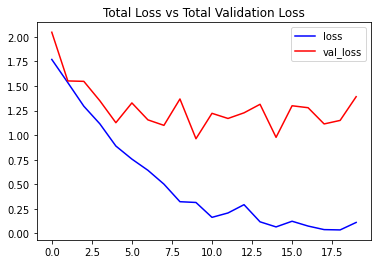

In [ ]:
# Visualize the training and validation loss metrices.
plot_metric(convlstm_model_training_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

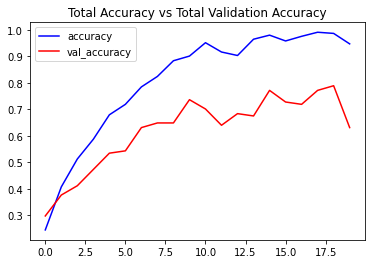

In [ ]:
# Visualize the training and validation accuracy metrices.
plot_metric(convlstm_model_training_history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')

**<font style="color:rgb(134,19,348)">Confusion Matrix Visualize</font>**

In [ ]:
# Evaluate the confusion_marix.
convlstm_model.predict(np.expand_dims(features_test[0], axis=0)).round(2)

1/1 [==============================] - 0s 103ms/step


array([[0.02, 0.  , 0.96, 0.  , 0.01, 0.01]], dtype=float32)

In [ ]:
y_test=np.argmax(labels_test,axis=-1)

In [ ]:
labels_test[0]

array([0., 0., 1., 0., 0., 0.], dtype=float32)

In [ ]:
# predict the features_test data
y_pred = np.argmax(convlstm_model.predict(features_test),axis=1)
y_pred

6/6 [==============================] - 17s 3s/step


array([2, 3, 1, 3, 0, 0, 0, 2, 4, 1, 2, 4, 2, 2, 3, 5, 4, 2, 0, 0, 3, 0,
       4, 2, 2, 3, 2, 3, 4, 3, 5, 4, 2, 2, 5, 4, 0, 1, 4, 0, 4, 5, 3, 0,
       3, 3, 2, 0, 5, 1, 1, 0, 0, 5, 3, 4, 5, 3, 2, 0, 0, 0, 0, 1, 2, 4,
       4, 1, 5, 2, 4, 2, 1, 1, 3, 4, 0, 3, 0, 0, 4, 4, 4, 5, 2, 0, 2, 0,
       5, 2, 1, 1, 0, 0, 4, 3, 2, 3, 0, 4, 5, 2, 1, 5, 2, 0, 5, 3, 5, 0,
       0, 0, 4, 0, 3, 4, 1, 4, 3, 2, 1, 1, 4, 3, 2, 4, 5, 0, 4, 2, 3, 2,
       1, 5, 0, 4, 0, 2, 4, 4, 4, 0, 5, 0, 0, 4, 1, 1, 0, 0, 2, 5, 3, 0,
       5, 4, 5, 5, 3, 2, 0, 4, 5, 1, 3, 1, 3, 5, 1, 3, 3, 2, 5, 2, 0, 5,
       1, 4, 4, 5, 0, 3, 4, 2, 5, 5, 4, 3, 2, 2, 2])

In [ ]:
# Display the Acuuracy
print('Accuracy score :', accuracy_score(y_test, y_pred))

Accuracy score : 0.8795811518324608


In [ ]:
# Plot the confusion_matrix of convlstm.
plt.figure(figsize=(16,9))
y_pred_labels = [np.argmax(label) for label in y_pred ]
print('Confusion Matrix')
cm = confusion_matrix(y_test, y_pred)

Confusion Matrix


<Figure size 1152x648 with 0 Axes>

Text(0.5, 51.0, 'Predicted Labels')

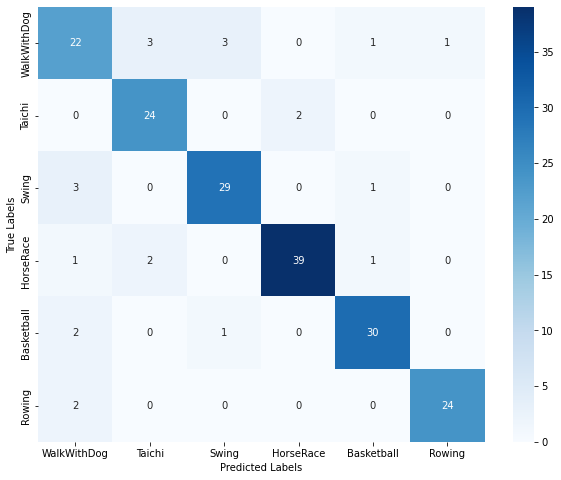

In [ ]:
# Visualize the confusion_matrix of convlstm.
plt.figure(figsize=(10,8))
x_axis_labels = ['WalkWithDog', 'Taichi', 'Swing', 'HorseRace','Basketball','Rowing']
y_axis_labels = ['WalkWithDog', 'Taichi', 'Swing', 'HorseRace','Basketball','Rowing']
sn.heatmap(data = cm, annot = True, cmap = 'Blues', xticklabels=x_axis_labels, yticklabels=y_axis_labels)
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')

In [ ]:
label_names = ['WalkWithDog', 'Taichi', 'Swing', 'HorseRace','Basketball','Rowing']
print(classification_report(y_test, y_pred,target_names=label_names))

              precision    recall  f1-score   support

 WalkWithDog       0.73      0.73      0.73        30
      Taichi       0.83      0.92      0.87        26
       Swing       0.88      0.88      0.88        33
   HorseRace       0.95      0.91      0.93        43
  Basketball       0.91      0.91      0.91        33
      Rowing       0.96      0.92      0.94        26

    accuracy                           0.88       191
   macro avg       0.88      0.88      0.88       191
weighted avg       0.88      0.88      0.88       191



 MODEL

In [90]:
def create_LRCN_model():
    '''
    This function will construct the required LRCN model.
    Returns:
        model: It is the required constructed LRCN model.
    '''

    # We will use a Sequential model for model construction.
    model = Sequential()

    # Define the Model Architecture.
    ########################################################################################################################

    model.add(TimeDistributed(Conv2D(16, (3, 3), padding='same',activation = 'relu'),
                              input_shape = (SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)))

    model.add(TimeDistributed(MaxPooling2D((4, 4))))
    model.add(TimeDistributed(Dropout(0.25)))

    model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((4, 4))))
    model.add(TimeDistributed(Dropout(0.25)))

    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Dropout(0.25)))

    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    #model.add(TimeDistributed(Dropout(0.25)))

    model.add(TimeDistributed(Flatten()))

    model.add(LSTM(128, name='LSTM', use_bias=False))

    model.add(Dense(len(CLASSES_LIST), activation = 'softmax'))

    ########################################################################################################################

    # Display the models summary.
    model.summary()

    # Return the constructed LRCN model.
    return model

In [95]:
# Construct the required LRCN model.
LRCN_model = create_LRCN_model()

# Display the success message.
print("Model Created Successfully!")

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_96 (TimeD  (None, 20, 64, 64, 16)    448       
 istributed)                                                     
                                                                 
 time_distributed_97 (TimeD  (None, 20, 16, 16, 16)    0         
 istributed)                                                     
                                                                 
 time_distributed_98 (TimeD  (None, 20, 16, 16, 16)    0         
 istributed)                                                     
                                                                 
 time_distributed_99 (TimeD  (None, 20, 16, 16, 32)    4640      
 istributed)                                                     
                                                                 
 time_distributed_100 (Time  (None, 20, 4, 4, 32)     

In [17]:
# Plot the structure of the contructed LRCN model.
# plot_model(LRCN_model, to_file = 'LRCN_model_structure_plot.png', show_shapes = True, show_layer_names = True)

In [96]:
# Create an Instance of Early Stopping Callback.
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 15, mode = 'min', restore_best_weights = True)

# Compile the model and specify loss function, optimizer and metrics to the model.
LRCN_model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])

# Start training the model.
LRCN_model_training_history = LRCN_model.fit(x = features_train, y = labels_train, epochs = 70, batch_size = 4 ,
                                             shuffle = True, validation_split = 0.2, callbacks = [early_stopping_callback])

Epoch 1/70
238/238 [==============================] - 9s 35ms/step - loss: 2.4706 - accuracy: 0.0896 - val_loss: 2.4808 - val_accuracy: 0.0504
Epoch 2/70
238/238 [==============================] - 7s 29ms/step - loss: 2.3297 - accuracy: 0.1602 - val_loss: 2.1898 - val_accuracy: 0.1429
Epoch 3/70
238/238 [==============================] - 7s 29ms/step - loss: 2.1164 - accuracy: 0.2413 - val_loss: 2.1968 - val_accuracy: 0.2059
Epoch 4/70
238/238 [==============================] - 7s 30ms/step - loss: 1.9278 - accuracy: 0.3361 - val_loss: 2.1364 - val_accuracy: 0.2437
Epoch 5/70
238/238 [==============================] - 7s 29ms/step - loss: 1.7185 - accuracy: 0.4341 - val_loss: 1.8254 - val_accuracy: 0.3992
Epoch 6/70
238/238 [==============================] - 7s 30ms/step - loss: 1.5554 - accuracy: 0.4763 - val_loss: 1.5344 - val_accuracy: 0.4370
Epoch 7/70
238/238 [==============================] - 7s 29ms/step - loss: 1.3810 - accuracy: 0.5248 - val_loss: 1.4467 - val_accuracy: 0.4622

In [98]:
# Evaluate the trained model.
model_evaluation_history = LRCN_model.evaluate(features_test, labels_test)

13/13 [==============================] - 1s 93ms/step - loss: 0.6277 - accuracy: 0.8485


In [102]:
# Get the loss and accuracy from model_evaluation_history.
model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history

# Define the string date format.
# Get the current Date and Time in a DateTime Object.
# Convert the DateTime object to string according to the style mentioned in date_time_format string.
date_time_format = '%Y_%m_%d__%H_%M_%S'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)

# Define a useful name for our model to make it easy for us while navigating through multiple saved models.
model_file_name = f'model/LRCN_model128___Date_Time_{current_date_time_string}___Loss_{model_evaluation_loss}___Accuracy_{model_evaluation_accuracy}.keras'

# Save the Model.
save_model(LRCN_model,model_file_name)

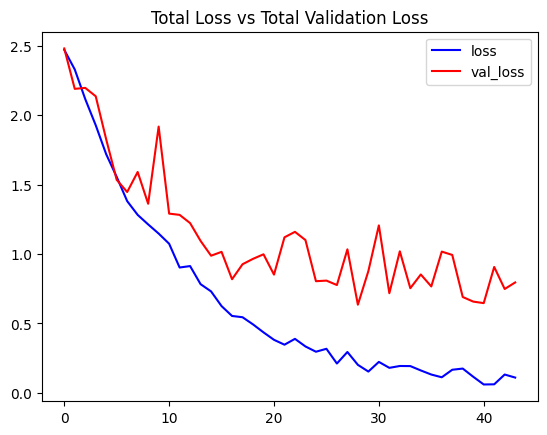

In [103]:
# Visualize the training and validation loss metrices.
plot_metric(LRCN_model_training_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

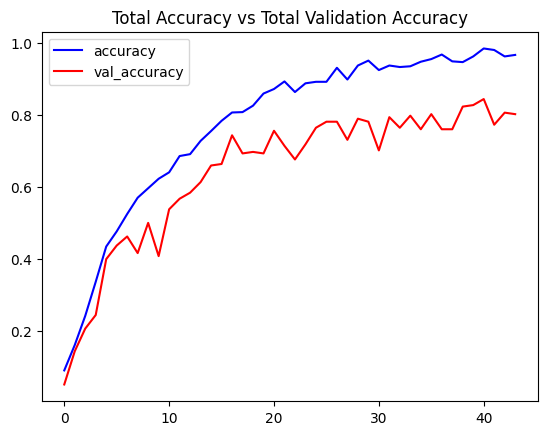

In [104]:
# Visualize the training and validation accuracy metrices.
plot_metric(LRCN_model_training_history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')

Confusion Matrix

In [105]:
y_test=np.argmax(labels_test,axis=-1)

In [106]:
# predict the features_test data
y_pred = np.argmax(LRCN_model.predict(features_test),axis=1)

13/13 [==============================] - 1s 54ms/step


In [107]:
# Display the Acuuracy
print('Accuracy score :', accuracy_score(y_test, y_pred))

Accuracy score : 0.8484848484848485


In [109]:
cm = confusion_matrix(y_test, y_pred)

Text(0.5, 58.7222222222222, 'Predicted Labels')

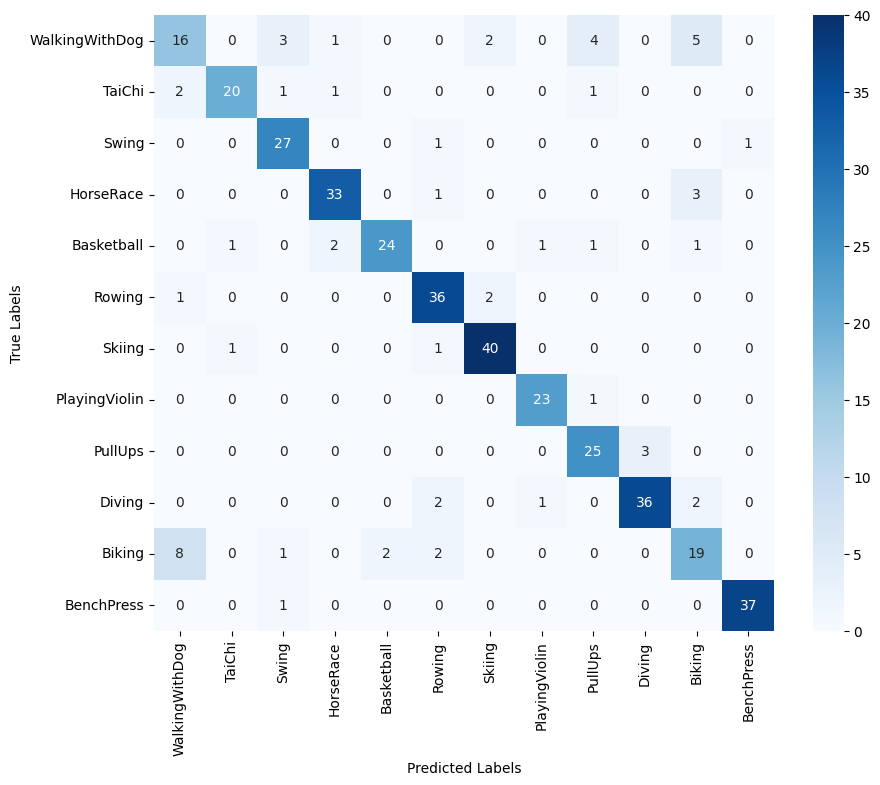

In [110]:
# Visualize the confusion_matrix of convlstm.
plt.figure(figsize=(10,8))
x_axis_labels = ["WalkingWithDog", "TaiChi", "Swing", "HorseRace","Basketball","Rowing","Skiing","PlayingViolin","PullUps","Diving","Biking","BenchPress"]
y_axis_labels = ["WalkingWithDog", "TaiChi", "Swing", "HorseRace","Basketball","Rowing","Skiing","PlayingViolin","PullUps","Diving","Biking","BenchPress"]
sn.heatmap(data = cm, annot = True, cmap = 'Blues', xticklabels=x_axis_labels, yticklabels=y_axis_labels)
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')

In [111]:
label_names = ["WalkingWithDog", "TaiChi", "Swing", "HorseRace","Basketball","Rowing","Skiing","PlayingViolin","PullUps","Diving","Biking","BenchPress"]
print(classification_report(y_test, y_pred,target_names=label_names))

                precision    recall  f1-score   support

WalkingWithDog       0.59      0.52      0.55        31
        TaiChi       0.91      0.80      0.85        25
         Swing       0.82      0.93      0.87        29
     HorseRace       0.89      0.89      0.89        37
    Basketball       0.92      0.80      0.86        30
        Rowing       0.84      0.92      0.88        39
        Skiing       0.91      0.95      0.93        42
 PlayingViolin       0.92      0.96      0.94        24
       PullUps       0.78      0.89      0.83        28
        Diving       0.92      0.88      0.90        41
        Biking       0.63      0.59      0.61        32
    BenchPress       0.97      0.97      0.97        38

      accuracy                           0.85       396
     macro avg       0.84      0.84      0.84       396
  weighted avg       0.85      0.85      0.85       396



## Approximation

In [112]:
import sys
sys.path.append('/Users/justin/Desktop/Year 4/FYP/main')
from iterative_approximation.Algorithm1 import *

import statistics

import sys
sys.path.append('/Users/justin/Desktop/Year 4/FYP/Code')
from iterative_approximation.Algorithm2 import *
from iterative_approximation.Algorithm2Step import *
from iterative_approximation.Algorithm2StepPruning import *
from iterative_approximation.Algorithm1 import *
import itertools
from utils.generate_groupings import *
import matplotlib.cm as cm

from utils.load_layer_weights_from_txt import *
from utils.save_layer_weight_to_txt import *

In [128]:
lrcn = load_model('model/LRCN_model128___Date_Time_2024_04_19__00_29_50___Loss_0.6276578903198242___Accuracy_0.8484848737716675.keras')

original_weight = lrcn.layers[-2].get_weights()

In [121]:
y_test = np.argmax(labels_test, axis=-1)
y_pred = np.argmax(lrcn(features_test), axis=1)
accuracy_baseline = accuracy_score(y_test, y_pred)

accuracy_baseline

0.8484848484848485

In [122]:
def extract_weight_array(layer):
    kernel, recurrent_kernel = layer.get_weights()

    I = np.hstack([kernel[:, :layer.units].T,recurrent_kernel[:, :layer.units].T])
    F = np.hstack([kernel[:, layer.units:2*layer.units].T,recurrent_kernel[:, layer.units:2*layer.units].T])
    O = np.hstack([kernel[:, 2*layer.units:3*layer.units].T,recurrent_kernel[:, 2*layer.units:3*layer.units].T])
    C = np.hstack([kernel[:, 3*layer.units:].T,recurrent_kernel[:, 3*layer.units:].T])
    return [I,F,O,C]


In [123]:
def set_layer_weight(layer,original_layer,weight_array):

    input_len = original_layer[0].shape[0]
    
    approximated_kernel = np.hstack([weight_array[0][:,:input_len].T,weight_array[1][:,:input_len].T,weight_array[2][:,:input_len].T,weight_array[3][:,:input_len].T])

    approximated_recurrent_kernel = np.hstack([weight_array[0][:,input_len:].T,weight_array[1][:,input_len:].T,weight_array[2][:,input_len:].T,weight_array[3][:,input_len:].T])

    approximated_weight = [approximated_kernel,approximated_recurrent_kernel]
    
    layer.set_weights(approximated_weight)


In [180]:
LSTM_layer = lrcn.layers[-2]
LSTM_layer.set_weights(original_weight)

W = extract_weight_array(lrcn.layers[-2])

MSE_list = [0.006,0.00575,0.0055,0.00525,0.005,0.00475,0.0045,0.00425,0.004,0.00375,0.0035,0.00325,0.003]

W1 = WeightArrayStepPruning(W,'array',0.001,128,192,1,1)

Single_W1_memory_footprints = []
Single_W1_mses = []

W_MSE = 0.01

Single_accuracy_result1 = []


for MSE in MSE_list:
    while W_MSE > MSE:
        W1.iterative_approximation_step1()
        W_MSE = W1.average_mse_array()

    W1_approximated = W1.current_reconstructed_weight_array
    Single_W1_memory_footprints.append(W1.memory_footprint_compressed)
    Single_W1_mses.append(W_MSE)

    set_layer_weight(LSTM_layer,original_weight,W1_approximated)
    
    y_pred = np.argmax(lrcn.predict(features_test),axis=1)
    accuracy = accuracy_score(y_test, y_pred)

    Single_accuracy_result1.append(accuracy)

LSTM_layer.set_weights(original_weight)

13/13 [==============================] - 1s 70ms/step


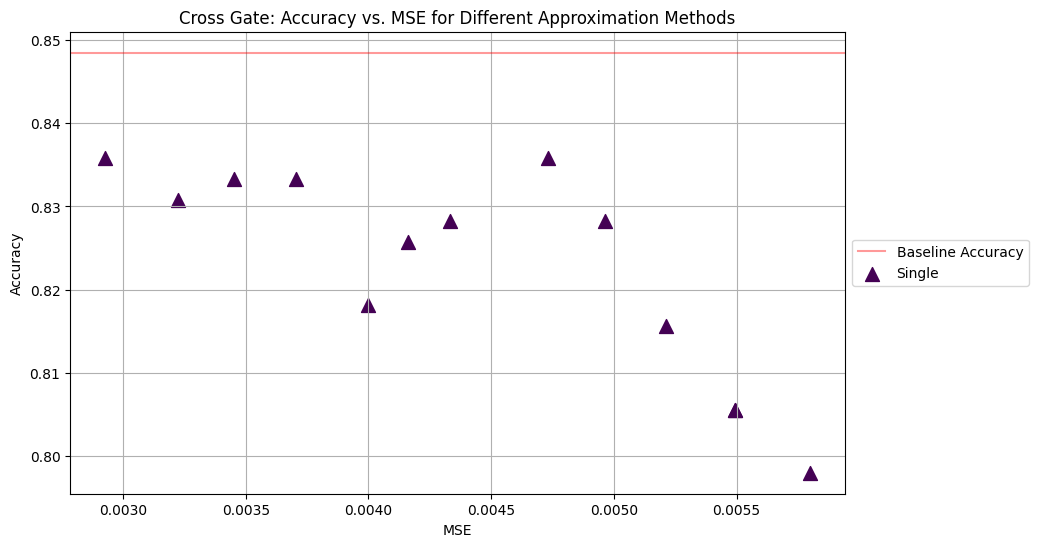

In [181]:
# Assuming W1_mses through W7_mses are defined corresponding to each accuracy_result
mse_lists = [Single_W1_mses]
accuracy_results = [Single_accuracy_result1]
label_list = ['Single']

# Number of different plots
num_plots = len(accuracy_results)

# Get the Viridis colormap
colors = cm.viridis(np.linspace(0, 1, num_plots))

# Plotting
plt.figure(figsize=(10, 6))
plt.axhline(y=accuracy_baseline, color='r', alpha = 0.4, label='Baseline Accuracy')

for i, (mse_list, accuracy_result) in enumerate(zip(mse_lists, accuracy_results)):
    plt.scatter(mse_list, accuracy_result, color=colors[i], marker='^', s=100,label=f'{label_list[i]}')

plt.xlabel('MSE')
plt.ylabel('Accuracy')
plt.title('Cross Gate: Accuracy vs. MSE for Different Approximation Methods')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(True)
plt.show()

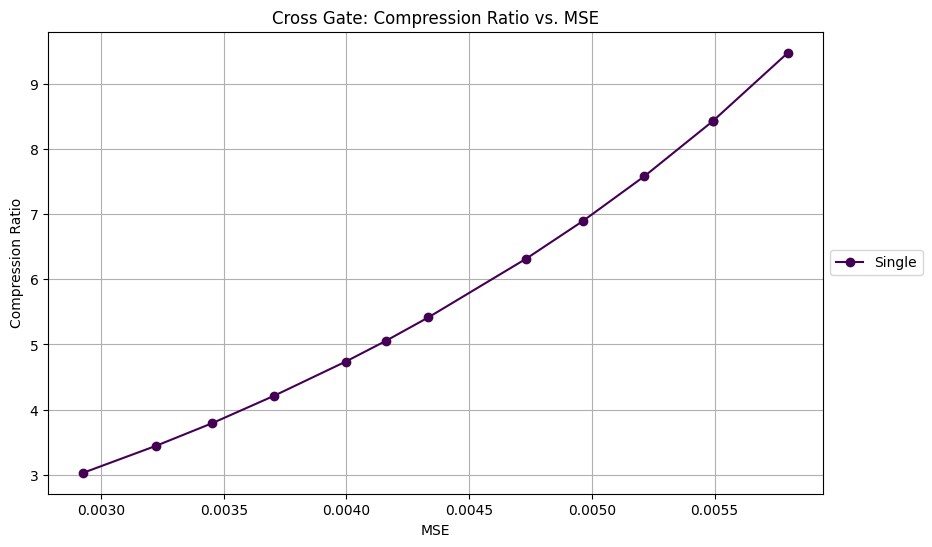

In [182]:
# Baseline memory footprint
baseline_mem_footprint = 3211264

mse_lists = [Single_W1_mses]
label_list = ['Single']

# Normalizing the memory footprints by the baseline
normalized_W1_mem_footprints = [baseline_mem_footprint/x for x in Single_W1_memory_footprints]

# Gathering all normalized memory footprints and MSEs
normalized_mem_footprints = [normalized_W1_mem_footprints]

# Number of different plots
num_plots = len(normalized_mem_footprints)

# Get the Viridis colormap
colors = cm.viridis(np.linspace(0, 1, num_plots))

# Plotting
plt.figure(figsize=(10, 6))
for i, (mem_footprints, mse_list) in enumerate(zip(normalized_mem_footprints, mse_lists)):
    plt.plot(mse_list, mem_footprints, color=colors[i], marker='o', label=f'{label_list[i]}', linestyle='-')

plt.xlabel('MSE')
plt.ylabel('Compression Ratio')
plt.title('Cross Gate: Compression Ratio vs. MSE')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(True)

plt.show()

In [183]:
LSTM_layer = lrcn.layers[-2]
LSTM_layer.set_weights(original_weight)

W = extract_weight_array(lrcn.layers[-2])

MSE_list = [0.006,0.00575,0.0055,0.00525,0.005,0.00475,0.0045,0.00425,0.004,0.00375,0.0035,0.00325,0.003]

W1 = WeightArrayStepPruning(W,'array',0.001,128,192,1,1)

Group4_W1_memory_footprints = []
Group4_W1_mses = []

W_MSE = 0.01

Group4_accuracy_result1 = []


for MSE in MSE_list:
    while W_MSE > MSE:
        W1.iterative_approximation_step2()
        W_MSE = W1.average_mse_array()

    W1_approximated = W1.current_reconstructed_weight_array
    Group4_W1_memory_footprints.append(W1.memory_footprint_compressed)
    Group4_W1_mses.append(W_MSE)

    set_layer_weight(LSTM_layer,original_weight,W1_approximated)
    
    y_pred = np.argmax(lrcn.predict(features_test),axis=1)
    accuracy = accuracy_score(y_test, y_pred)

    Group4_accuracy_result1.append(accuracy)

LSTM_layer.set_weights(original_weight)


W1 = WeightArrayStepPruning(W,'array',0.001,128,192,1,1)

Group4_W2_memory_footprints = []
Group4_W2_mses = []

W_MSE = 0.01

Group4_accuracy_result2 = []


for MSE in MSE_list:
    while W_MSE > MSE:
        W1.iterative_approximation_step2_norm('fro')
        W_MSE = W1.average_mse_array()

    W1_approximated = W1.current_reconstructed_weight_array
    Group4_W2_memory_footprints.append(W1.memory_footprint_compressed)
    Group4_W2_mses.append(W_MSE)

    set_layer_weight(LSTM_layer,original_weight,W1_approximated)
    
    y_pred = np.argmax(lrcn.predict(features_test),axis=1)
    accuracy = accuracy_score(y_test, y_pred)

    Group4_accuracy_result2.append(accuracy)

LSTM_layer.set_weights(original_weight)

W1 = WeightArrayStepPruning(W,'array',0.001,128,192,1,1)

Group4_W3_memory_footprints = []
Group4_W3_mses = []

W_MSE = 0.01

Group4_accuracy_result3 = []


for MSE in MSE_list:
    while W_MSE > MSE:
        W1.iterative_approximation_step2_norm('spec')
        W_MSE = W1.average_mse_array()

    W1_approximated = W1.current_reconstructed_weight_array
    Group4_W3_memory_footprints.append(W1.memory_footprint_compressed)
    Group4_W3_mses.append(W_MSE)

    set_layer_weight(LSTM_layer,original_weight,W1_approximated)
    
    y_pred = np.argmax(lrcn.predict(features_test),axis=1)
    accuracy = accuracy_score(y_test, y_pred)

    Group4_accuracy_result3.append(accuracy)

LSTM_layer.set_weights(original_weight)

13/13 [==============================] - 1s 46ms/step


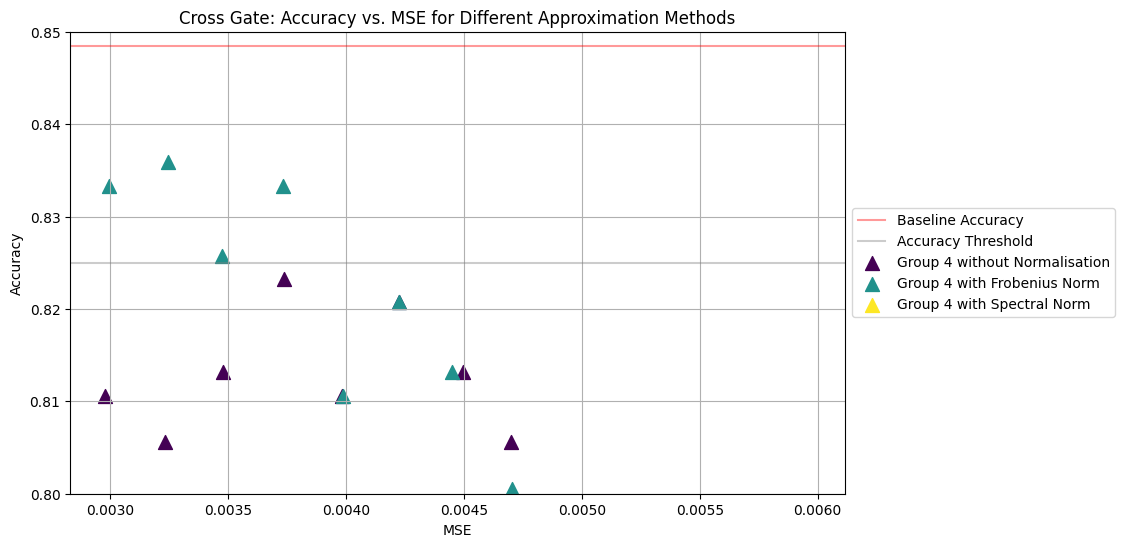

In [213]:
# Assuming W1_mses through W7_mses are defined corresponding to each accuracy_result
mse_lists = [Group4_W1_mses, Group4_W2_mses, Group4_W3_mses]
accuracy_results = [Group4_accuracy_result1, Group4_accuracy_result2, Group4_accuracy_result3]
label_list = ['Group 4 without Normalisation','Group 4 with Frobenius Norm','Group 4 with Spectral Norm']

# Number of different plots
num_plots = len(accuracy_results)

# Get the Viridis colormap
colors = cm.viridis(np.linspace(0, 1, num_plots))

# Plotting
plt.figure(figsize=(10, 6))
plt.axhline(y=accuracy_baseline, color='r', alpha = 0.4, label='Baseline Accuracy')
plt.axhline(y=0.825, color='gray', alpha = 0.4, label='Accuracy Threshold')
for i, (mse_list, accuracy_result) in enumerate(zip(mse_lists, accuracy_results)):
    plt.scatter(mse_list, accuracy_result, color=colors[i], marker='^', s=100,label=f'{label_list[i]}')

plt.xlabel('MSE')
plt.ylim([0.8,0.85])
plt.ylabel('Accuracy')
plt.title('Cross Gate: Accuracy vs. MSE for Different Approximation Methods')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(True)
plt.show()

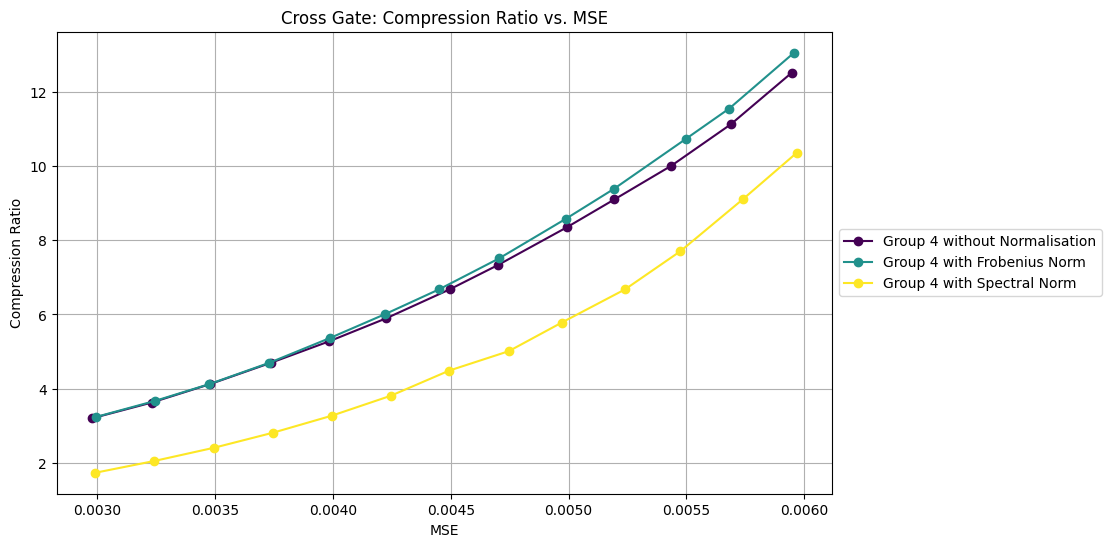

In [185]:
# Baseline memory footprint
baseline_mem_footprint = 3211264

mse_lists = [Group4_W1_mses, Group4_W2_mses, Group4_W3_mses]
label_list = ['Group 4 without Normalisation','Group 4 with Frobenius Norm','Group 4 with Spectral Norm']

# Normalizing the memory footprints by the baseline
normalized_W1_mem_footprints = [baseline_mem_footprint/x for x in Group4_W1_memory_footprints]
normalized_W2_mem_footprints = [baseline_mem_footprint/x for x in Group4_W2_memory_footprints]
normalized_W3_mem_footprints = [baseline_mem_footprint/x for x in Group4_W3_memory_footprints]

# Gathering all normalized memory footprints and MSEs
normalized_mem_footprints = [normalized_W1_mem_footprints, normalized_W2_mem_footprints, normalized_W3_mem_footprints]

# Number of different plots
num_plots = len(normalized_mem_footprints)

# Get the Viridis colormap
colors = cm.viridis(np.linspace(0, 1, num_plots))

# Plotting
plt.figure(figsize=(10, 6))
for i, (mem_footprints, mse_list) in enumerate(zip(normalized_mem_footprints, mse_lists)):
    plt.plot(mse_list, mem_footprints, color=colors[i], marker='o', label=f'{label_list[i]}', linestyle='-')

plt.xlabel('MSE')
plt.ylabel('Compression Ratio')
plt.title('Cross Gate: Compression Ratio vs. MSE')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(True)

plt.show()

In [186]:
LSTM_layer = lrcn.layers[-2]
LSTM_layer.set_weights(original_weight)

W = extract_weight_array(lrcn.layers[-2])

MSE_list = [0.006,0.00575,0.0055,0.00525,0.005,0.00475,0.0045,0.00425,0.004,0.00375,0.0035,0.00325,0.003]

W1 = WeightArrayStepPruning(W,'weight',0.001,128,192,1,1)

Stack4_W1_memory_footprints = []
Stack4_W1_mses = []

W_MSE = 0.01

Stack4_accuracy_result1 = []


for MSE in MSE_list:
    while W_MSE > MSE:
        W1_approximated = W1.iterative_approximation_step3()
        W_MSE = W1.average_mse_weight()

    Stack4_W1_memory_footprints.append(W1.memory_footprint_compressed)
    Stack4_W1_mses.append(W_MSE)

    set_layer_weight(LSTM_layer,original_weight,W1_approximated)
    
    y_pred = np.argmax(lrcn.predict(features_test),axis=1)
    accuracy = accuracy_score(y_test, y_pred)

    Stack4_accuracy_result1.append(accuracy)

LSTM_layer.set_weights(original_weight)


W1 = WeightArrayStepPruning(W,'weight',0.001,128,192,1,1)

Stack4_W2_memory_footprints = []
Stack4_W2_mses = []

W_MSE = 0.01

Stack4_accuracy_result2 = []


for MSE in MSE_list:
    while W_MSE > MSE:
        W1_approximated = W1.iterative_approximation_step3_norm('fro')
        W_MSE = W1.average_mse_weight()

    Stack4_W2_memory_footprints.append(W1.memory_footprint_compressed)
    Stack4_W2_mses.append(W_MSE)

    set_layer_weight(LSTM_layer,original_weight,W1_approximated)
    
    y_pred = np.argmax(lrcn.predict(features_test),axis=1)
    accuracy = accuracy_score(y_test, y_pred)

    Stack4_accuracy_result2.append(accuracy)

LSTM_layer.set_weights(original_weight)

W1 = WeightArrayStepPruning(W,'weight',0.001,128,192,1,1)

Stack4_W3_memory_footprints = []
Stack4_W3_mses = []

W_MSE = 0.01

Stack4_accuracy_result3 = []


for MSE in MSE_list:
    while W_MSE > MSE:
        W1_approximated = W1.iterative_approximation_step3_norm('spec')
        W_MSE = W1.average_mse_weight()

    Stack4_W3_memory_footprints.append(W1.memory_footprint_compressed)
    Stack4_W3_mses.append(W_MSE)

    set_layer_weight(LSTM_layer,original_weight,W1_approximated)
    
    y_pred = np.argmax(lrcn.predict(features_test),axis=1)
    accuracy = accuracy_score(y_test, y_pred)

    Stack4_accuracy_result3.append(accuracy)

LSTM_layer.set_weights(original_weight)

13/13 [==============================] - 1s 47ms/step


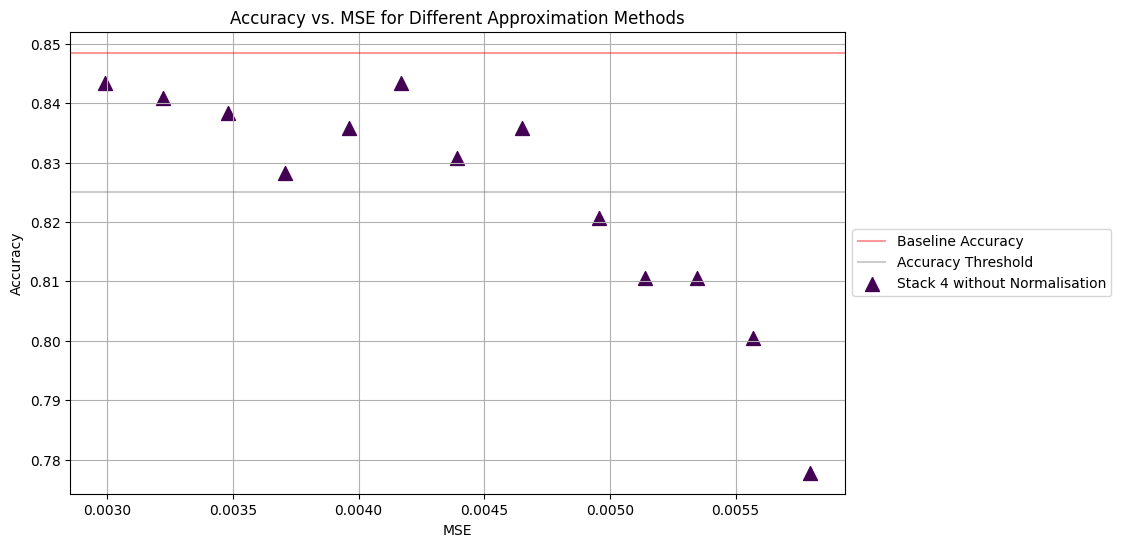

In [212]:
# Assuming W1_mses through W7_mses are defined corresponding to each accuracy_result
mse_lists = [Stack4_W1_mses, Stack4_W2_mses, Stack4_W3_mses]
accuracy_results = [Stack4_accuracy_result1, Stack4_accuracy_result2, Stack4_accuracy_result3]
label_list = ['Stack 4 without Normalisation','Stack 4 with Frob Norm','Stack 4 with Spec Norm']

# Number of different plots
num_plots = len(accuracy_results)

# Get the Viridis colormap
colors = cm.viridis(np.linspace(0, 1, num_plots))

# Plotting
plt.figure(figsize=(10, 6))
plt.axhline(y=accuracy_baseline, color='r', alpha = 0.4, label='Baseline Accuracy')
plt.axhline(y=0.825, color='gray', alpha = 0.4, label='Accuracy Threshold')

for i, (mse_list, accuracy_result) in enumerate(zip(mse_lists, accuracy_results)):
    plt.scatter(mse_list, accuracy_result, color=colors[i], marker='^', s=100,label=f'{label_list[i]}')

plt.xlabel('MSE')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. MSE for Different Approximation Methods')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(True)
plt.show()

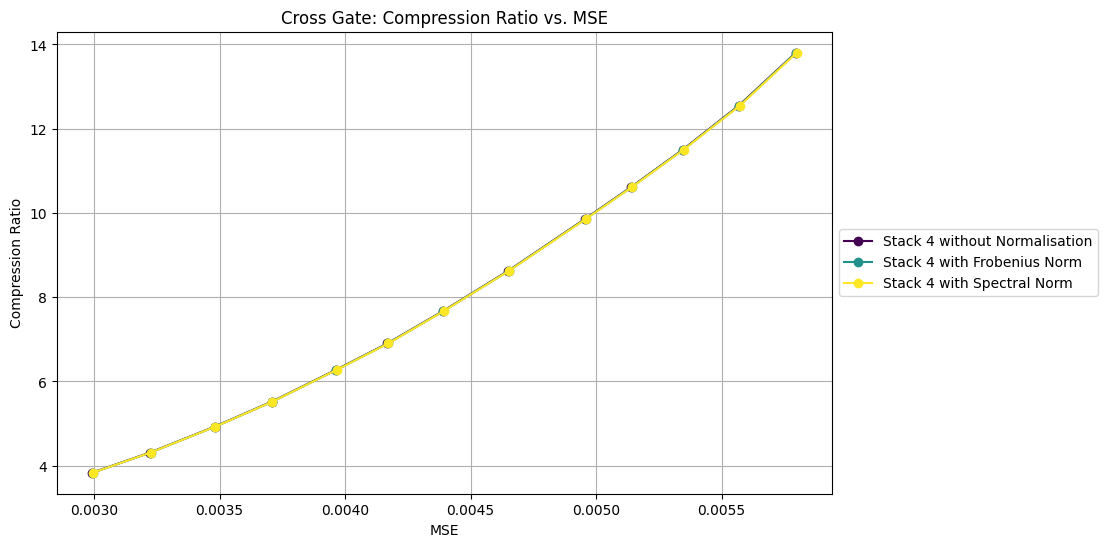

In [188]:
# Baseline memory footprint
baseline_mem_footprint = 3211264

mse_lists = [Stack4_W1_mses, Stack4_W2_mses, Stack4_W3_mses]
label_list = ['Stack 4 without Normalisation','Stack 4 with Frobenius Norm','Stack 4 with Spectral Norm']

# Normalizing the memory footprints by the baseline
normalized_W1_mem_footprints = [baseline_mem_footprint/x for x in Stack4_W1_memory_footprints]
normalized_W2_mem_footprints = [baseline_mem_footprint/x for x in Stack4_W2_memory_footprints]
normalized_W3_mem_footprints = [baseline_mem_footprint/x for x in Stack4_W3_memory_footprints]

# Gathering all normalized memory footprints and MSEs
normalized_mem_footprints = [normalized_W1_mem_footprints, normalized_W2_mem_footprints, normalized_W3_mem_footprints]

# Number of different plots
num_plots = len(normalized_mem_footprints)

# Get the Viridis colormap
colors = cm.viridis(np.linspace(0, 1, num_plots))

# Plotting
plt.figure(figsize=(10, 6))
for i, (mem_footprints, mse_list) in enumerate(zip(normalized_mem_footprints, mse_lists)):
    plt.plot(mse_list, mem_footprints, color=colors[i], marker='o', label=f'{label_list[i]}', linestyle='-')

plt.xlabel('MSE')
plt.ylabel('Compression Ratio')
plt.title('Cross Gate: Compression Ratio vs. MSE')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(True)

plt.show()

In [189]:
LSTM_layer = lrcn.layers[-2]
LSTM_layer.set_weights(original_weight)

W = extract_weight_array(lrcn.layers[-2])

MSE_list = [0.006,0.00575,0.0055,0.00525,0.005,0.00475,0.0045,0.00425,0.004,0.00375,0.0035,0.00325,0.003]

# hybrid 1
W1 = WeightArrayStepPruning(W,'array',0.001,128,192,1,1)
W1_memory_footprints = []
W1_mses = []

W_MSE = 0.01

accuracy_result1 = []

for MSE in MSE_list:
    while W_MSE > MSE:
        W1.hybrid_iterative_approximation_step(1)
        W_MSE = W1.average_mse_array()

    W1_approximated = W1.current_reconstructed_weight_array

    W1_memory_footprints.append(W1.memory_footprint_compressed)
    W1_mses.append(W_MSE)

    set_layer_weight(LSTM_layer,original_weight,W1_approximated)

    y_pred = np.argmax(lrcn.predict(features_test),axis=1)
    accuracy = accuracy_score(y_test, y_pred)

    accuracy_result1.append(accuracy)

LSTM_layer.set_weights(original_weight)

# hybrid 3
W1 = WeightArrayStepPruning(W,'array',0.001,128,192,1,1)
W2_memory_footprints = []
W2_mses = []

W_MSE = 0.01

accuracy_result2 = []

for MSE in MSE_list:
    while W_MSE > MSE:
        W1.hybrid_iterative_approximation_step(3)
        W_MSE = W1.average_mse_array()

    W1_approximated = W1.current_reconstructed_weight_array

    W2_memory_footprints.append(W1.memory_footprint_compressed)
    W2_mses.append(W_MSE)

    set_layer_weight(LSTM_layer,original_weight,W1_approximated)

    y_pred = np.argmax(lrcn.predict(features_test),axis=1)
    accuracy = accuracy_score(y_test, y_pred)

    accuracy_result2.append(accuracy)

LSTM_layer.set_weights(original_weight)


# hybrid 5
W1 = WeightArrayStepPruning(W,'array',0.001,128,192,1,1)
W3_memory_footprints = []
W3_mses = []

W_MSE = 0.01

accuracy_result3 = []

for MSE in MSE_list:
    while W_MSE > MSE:
        W1.hybrid_iterative_approximation_step(5)
        W_MSE = W1.average_mse_array()

    W1_approximated = W1.current_reconstructed_weight_array

    W3_memory_footprints.append(W1.memory_footprint_compressed)
    W3_mses.append(W_MSE)

    set_layer_weight(LSTM_layer,original_weight,W1_approximated)

    y_pred = np.argmax(lrcn.predict(features_test),axis=1)
    accuracy = accuracy_score(y_test, y_pred)

    accuracy_result3.append(accuracy)

LSTM_layer.set_weights(original_weight)


# hybrid 6
W1 = WeightArrayStepPruning(W,'array',0.001,128,192,1,1)
W4_memory_footprints = []
W4_mses = []

W_MSE = 0.01

accuracy_result4 = []

for MSE in MSE_list:
    while W_MSE > MSE:
        W1.hybrid_iterative_approximation_step(6)
        W_MSE = W1.average_mse_array()

    W1_approximated = W1.current_reconstructed_weight_array

    W4_memory_footprints.append(W1.memory_footprint_compressed)
    W4_mses.append(W_MSE)

    set_layer_weight(LSTM_layer,original_weight,W1_approximated)

    y_pred = np.argmax(lrcn.predict(features_test),axis=1)
    accuracy = accuracy_score(y_test, y_pred)

    accuracy_result4.append(accuracy)

LSTM_layer.set_weights(original_weight)

13/13 [==============================] - 1s 50ms/step


In [190]:
LSTM_layer = lrcn.layers[-2]
LSTM_layer.set_weights(original_weight)

W = extract_weight_array(lrcn.layers[-2])

MSE_list = [0.006,0.00575,0.0055,0.00525,0.005,0.00475,0.0045,0.00425,0.004,0.00375,0.0035,0.00325,0.003]

# hybrid 1
W1 = WeightArrayStepPruning(W,'array',0.001,128,192,1,1)
W5_memory_footprints = []
W5_mses = []

W_MSE = 0.01

accuracy_result5 = []

for MSE in MSE_list:
    while W_MSE > MSE:
        W1.hybrid_iterative_approximation_step_norm(1,'fro')
        W_MSE = W1.average_mse_array()

    W1_approximated = W1.current_reconstructed_weight_array

    W5_memory_footprints.append(W1.memory_footprint_compressed)
    W5_mses.append(W_MSE)

    set_layer_weight(LSTM_layer,original_weight,W1_approximated)

    y_pred = np.argmax(lrcn.predict(features_test),axis=1)
    accuracy = accuracy_score(y_test, y_pred)

    accuracy_result5.append(accuracy)

LSTM_layer.set_weights(original_weight)

# hybrid 3
W1 = WeightArrayStepPruning(W,'array',0.001,128,192,1,1)
W6_memory_footprints = []
W6_mses = []

W_MSE = 0.01

accuracy_result6 = []

for MSE in MSE_list:
    while W_MSE > MSE:
        W1.hybrid_iterative_approximation_step_norm(3,'fro')
        W_MSE = W1.average_mse_array()

    W1_approximated = W1.current_reconstructed_weight_array

    W6_memory_footprints.append(W1.memory_footprint_compressed)
    W6_mses.append(W_MSE)

    set_layer_weight(LSTM_layer,original_weight,W1_approximated)

    y_pred = np.argmax(lrcn.predict(features_test),axis=1)
    accuracy = accuracy_score(y_test, y_pred)

    accuracy_result6.append(accuracy)

LSTM_layer.set_weights(original_weight)

# hybrid 6
W1 = WeightArrayStepPruning(W,'array',0.001,128,192,1,1)
W7_memory_footprints = []
W7_mses = []

W_MSE = 0.01

accuracy_result7 = []

for MSE in MSE_list:
    while W_MSE > MSE:
        W1.hybrid_iterative_approximation_step_norm(6,'fro')
        W_MSE = W1.average_mse_array()

    W1_approximated = W1.current_reconstructed_weight_array

    W7_memory_footprints.append(W1.memory_footprint_compressed)
    W7_mses.append(W_MSE)

    set_layer_weight(LSTM_layer,original_weight,W1_approximated)

    y_pred = np.argmax(lrcn.predict(features_test),axis=1)
    accuracy = accuracy_score(y_test, y_pred)

    accuracy_result7.append(accuracy)

LSTM_layer.set_weights(original_weight)

13/13 [==============================] - 1s 47ms/step


In [191]:
LSTM_layer = lrcn.layers[-2]
LSTM_layer.set_weights(original_weight)

W = extract_weight_array(lrcn.layers[-2])

MSE_list = [0.006,0.00575,0.0055,0.00525,0.005,0.00475,0.0045,0.00425,0.004,0.00375,0.0035,0.00325,0.003]

# hybrid 1
W1 = WeightArrayStepPruning(W,'array',0.001,128,192,1,1)
W8_memory_footprints = []
W8_mses = []

W_MSE = 0.01

accuracy_result8 = []

for MSE in MSE_list:
    while W_MSE > MSE:
        W1.hybrid_iterative_approximation_step_norm(1,'spec')
        W_MSE = W1.average_mse_array()

    W1_approximated = W1.current_reconstructed_weight_array

    W8_memory_footprints.append(W1.memory_footprint_compressed)
    W8_mses.append(W_MSE)

    set_layer_weight(LSTM_layer,original_weight,W1_approximated)

    y_pred = np.argmax(lrcn.predict(features_test),axis=1)
    accuracy = accuracy_score(y_test, y_pred)

    accuracy_result8.append(accuracy)

LSTM_layer.set_weights(original_weight)

# hybrid 3
W1 = WeightArrayStepPruning(W,'array',0.001,128,192,1,1)
W9_memory_footprints = []
W9_mses = []

W_MSE = 0.01

accuracy_result9 = []

for MSE in MSE_list:
    while W_MSE > MSE:
        W1.hybrid_iterative_approximation_step_norm(3,'spec')
        W_MSE = W1.average_mse_array()

    W1_approximated = W1.current_reconstructed_weight_array

    W9_memory_footprints.append(W1.memory_footprint_compressed)
    W9_mses.append(W_MSE)

    set_layer_weight(LSTM_layer,original_weight,W1_approximated)

    y_pred = np.argmax(lrcn.predict(features_test),axis=1)
    accuracy = accuracy_score(y_test, y_pred)

    accuracy_result9.append(accuracy)

LSTM_layer.set_weights(original_weight)

# hybrid 6
W1 = WeightArrayStepPruning(W,'array',0.001,128,192,1,1)
W10_memory_footprints = []
W10_mses = []

W_MSE = 0.01

accuracy_result10 = []

for MSE in MSE_list:
    while W_MSE > MSE:
        W1.hybrid_iterative_approximation_step_norm(6,'spec')
        W_MSE = W1.average_mse_array()

    W1_approximated = W1.current_reconstructed_weight_array

    W10_memory_footprints.append(W1.memory_footprint_compressed)
    W10_mses.append(W_MSE)

    set_layer_weight(LSTM_layer,original_weight,W1_approximated)

    y_pred = np.argmax(lrcn.predict(features_test),axis=1)
    accuracy = accuracy_score(y_test, y_pred)

    accuracy_result10.append(accuracy)

LSTM_layer.set_weights(original_weight)

13/13 [==============================] - 1s 46ms/step


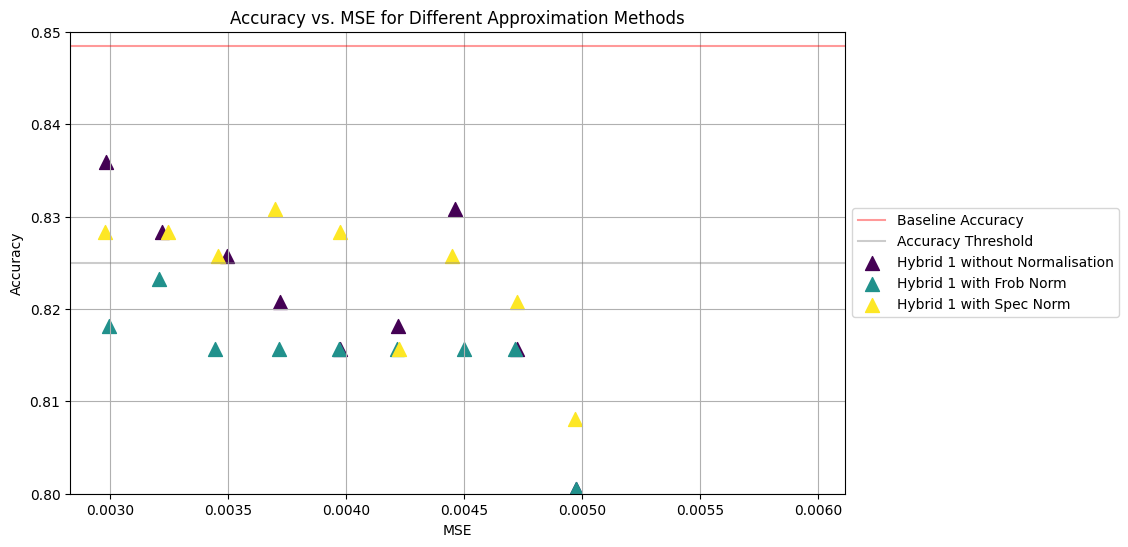

In [208]:
# Assuming W1_mses through W7_mses are defined corresponding to each accuracy_result
# mse_lists = [W1_mses, W2_mses, W3_mses,W4_mses, W5_mses, W6_mses,W7_mses, W8_mses, W9_mses,W10_mses]
# accuracy_results = [accuracy_result1, accuracy_result2, accuracy_result3,accuracy_result4, accuracy_result5, accuracy_result6,accuracy_result7, accuracy_result8, accuracy_result9,accuracy_result10]
# label_list = ['Hybrid 1 without Normalisation','Hybrid 3 without Normalisation','Hybrid 5 without Normalisation','Hybrid 6 without Normalisation','Hybrid 1 with Frob Norm','Hybrid 3 with Frob Norm','Hybrid 6 with Frob Norm','Hybrid 1 with Spec Norm','Hybrid 3 with Spec Norm','Hybrid 6 with Spec Norm']

mse_lists = [W1_mses, W5_mses, W8_mses]
accuracy_results = [accuracy_result1, accuracy_result5, accuracy_result8]
label_list = ['Hybrid 1 without Normalisation','Hybrid 1 with Frob Norm','Hybrid 1 with Spec Norm']

# Number of different plots
num_plots = len(accuracy_results)

# Get the Viridis colormap
colors = cm.viridis(np.linspace(0, 1, num_plots))

# Plotting
plt.figure(figsize=(10, 6))
plt.axhline(y=accuracy_baseline, color='r', alpha = 0.4, label='Baseline Accuracy')

plt.axhline(y=0.825, color='gray', alpha = 0.4, label='Accuracy Threshold')

for i, (mse_list, accuracy_result) in enumerate(zip(mse_lists, accuracy_results)):
    plt.scatter(mse_list, accuracy_result, color=colors[i], marker='^', s=100,label=f'{label_list[i]}')

plt.xlabel('MSE')
plt.ylabel('Accuracy')
plt.ylim([0.8,0.85])
plt.title('Accuracy vs. MSE for Different Approximation Methods')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(True)
plt.show()

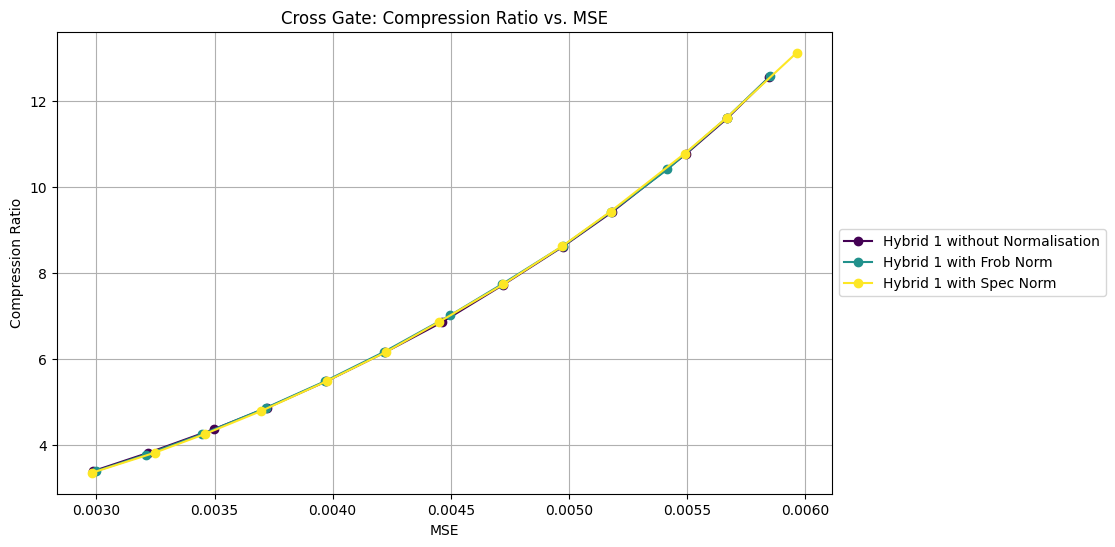

In [193]:
# Baseline memory footprint
baseline_mem_footprint = 3211264

mse_lists = [W1_mses, W5_mses, W8_mses]
label_list = ['Hybrid 1 without Normalisation','Hybrid 1 with Frob Norm','Hybrid 1 with Spec Norm']

# Normalizing the memory footprints by the baseline
normalized_W1_mem_footprints = [baseline_mem_footprint/x for x in W1_memory_footprints]
normalized_W2_mem_footprints = [baseline_mem_footprint/x for x in W5_memory_footprints]
normalized_W3_mem_footprints = [baseline_mem_footprint/x for x in W8_memory_footprints]

# Gathering all normalized memory footprints and MSEs
normalized_mem_footprints = [normalized_W1_mem_footprints, normalized_W2_mem_footprints, normalized_W3_mem_footprints]

# Number of different plots
num_plots = len(normalized_mem_footprints)

# Get the Viridis colormap
colors = cm.viridis(np.linspace(0, 1, num_plots))

# Plotting
plt.figure(figsize=(10, 6))
for i, (mem_footprints, mse_list) in enumerate(zip(normalized_mem_footprints, mse_lists)):
    plt.plot(mse_list, mem_footprints, color=colors[i], marker='o', label=f'{label_list[i]}', linestyle='-')

plt.xlabel('MSE')
plt.ylabel('Compression Ratio')
plt.title('Cross Gate: Compression Ratio vs. MSE')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(True)

plt.show()

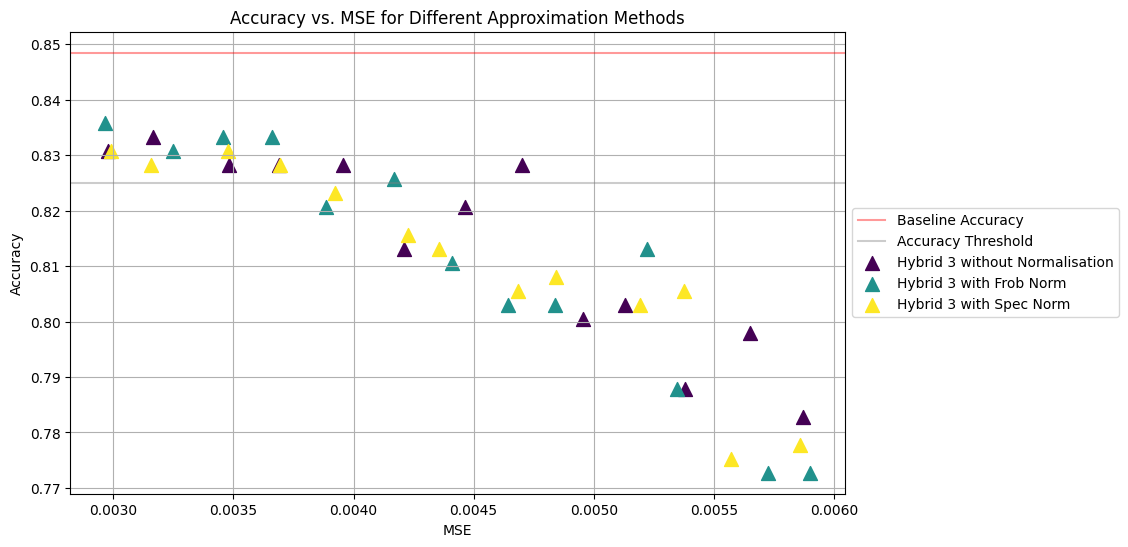

In [207]:
mse_lists = [W2_mses, W6_mses, W9_mses]
accuracy_results = [accuracy_result2, accuracy_result6, accuracy_result9]
label_list = ['Hybrid 3 without Normalisation','Hybrid 3 with Frob Norm', 'Hybrid 3 with Spec Norm']

# Number of different plots
num_plots = len(accuracy_results)

# Get the Viridis colormap
colors = cm.viridis(np.linspace(0, 1, num_plots))

# Plotting
plt.figure(figsize=(10, 6))
plt.axhline(y=accuracy_baseline, color='r', alpha = 0.4, label='Baseline Accuracy')
plt.axhline(y=0.825, color='gray', alpha = 0.4, label='Accuracy Threshold')

for i, (mse_list, accuracy_result) in enumerate(zip(mse_lists, accuracy_results)):
    plt.scatter(mse_list, accuracy_result, color=colors[i], marker='^', s=100,label=f'{label_list[i]}')

plt.xlabel('MSE')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. MSE for Different Approximation Methods')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(True)
plt.show()

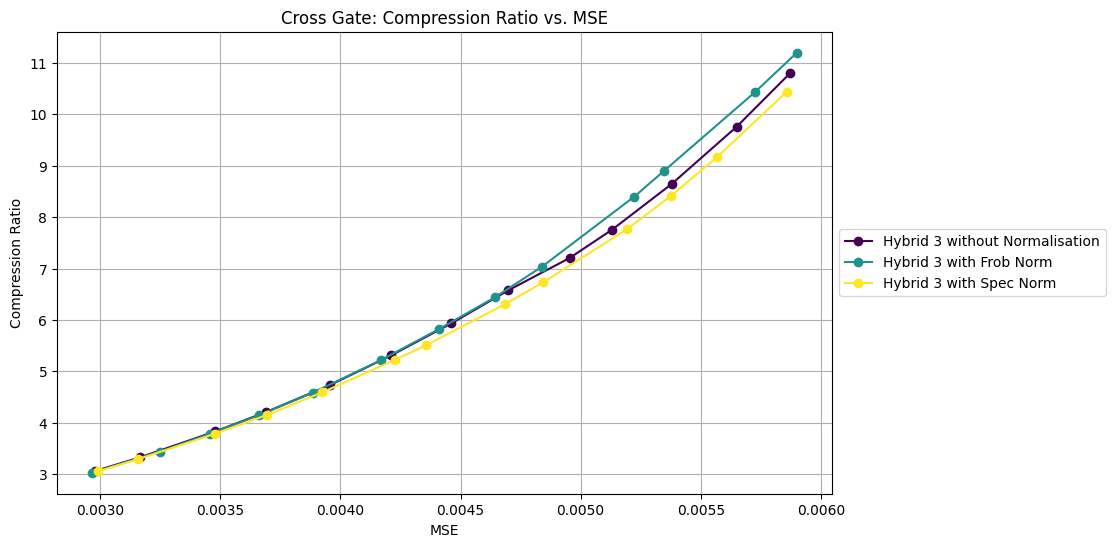

In [195]:
# Baseline memory footprint
baseline_mem_footprint = 3211264

mse_lists = [ W2_mses, W6_mses, W9_mses]
label_list = ['Hybrid 3 without Normalisation','Hybrid 3 with Frob Norm', 'Hybrid 3 with Spec Norm']

# Normalizing the memory footprints by the baseline
normalized_W1_mem_footprints = [baseline_mem_footprint/x for x in W2_memory_footprints]
normalized_W2_mem_footprints = [baseline_mem_footprint/x for x in W6_memory_footprints]
normalized_W3_mem_footprints = [baseline_mem_footprint/x for x in W9_memory_footprints]

# Gathering all normalized memory footprints and MSEs
normalized_mem_footprints = [normalized_W1_mem_footprints, normalized_W2_mem_footprints, normalized_W3_mem_footprints]

# Number of different plots
num_plots = len(normalized_mem_footprints)

# Get the Viridis colormap
colors = cm.viridis(np.linspace(0, 1, num_plots))

# Plotting
plt.figure(figsize=(10, 6))
for i, (mem_footprints, mse_list) in enumerate(zip(normalized_mem_footprints, mse_lists)):
    plt.plot(mse_list, mem_footprints, color=colors[i], marker='o', label=f'{label_list[i]}', linestyle='-')

plt.xlabel('MSE')
plt.ylabel('Compression Ratio')
plt.title('Cross Gate: Compression Ratio vs. MSE')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(True)

plt.show()

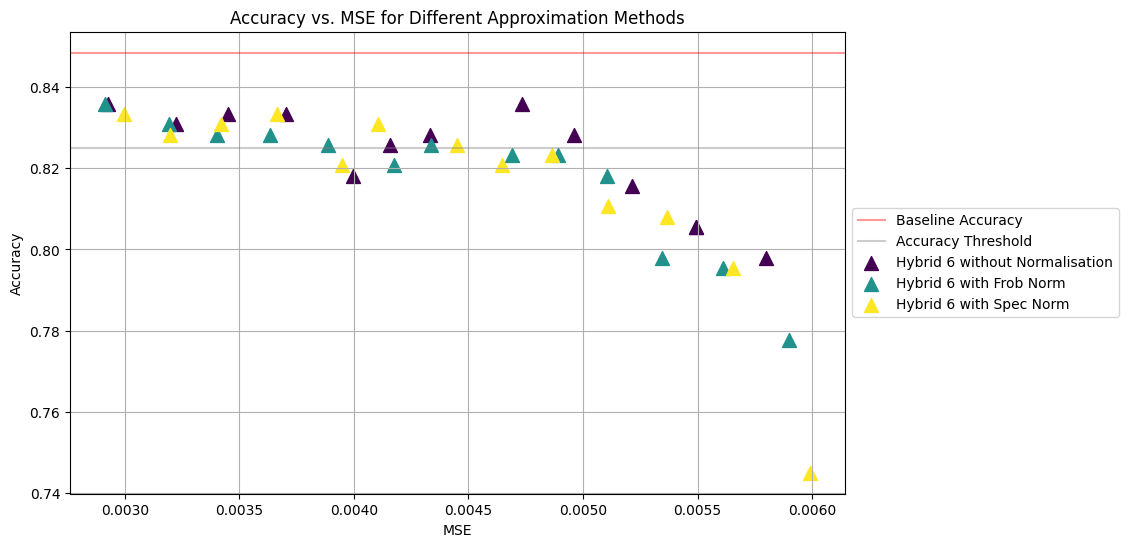

In [206]:
mse_lists = [ W4_mses, W7_mses, W10_mses]
accuracy_results = [accuracy_result4, accuracy_result7, accuracy_result10]
label_list = ['Hybrid 6 without Normalisation','Hybrid 6 with Frob Norm', 'Hybrid 6 with Spec Norm']

# Number of different plots
num_plots = len(accuracy_results)

# Get the Viridis colormap
colors = cm.viridis(np.linspace(0, 1, num_plots))

# Plotting
plt.figure(figsize=(10, 6))
plt.axhline(y=accuracy_baseline, color='r', alpha = 0.4, label='Baseline Accuracy')
plt.axhline(y=0.825, color='gray', alpha = 0.4, label='Accuracy Threshold')

for i, (mse_list, accuracy_result) in enumerate(zip(mse_lists, accuracy_results)):
    plt.scatter(mse_list, accuracy_result, color=colors[i], marker='^', s=100,label=f'{label_list[i]}')

plt.xlabel('MSE')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. MSE for Different Approximation Methods')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(True)
plt.show()

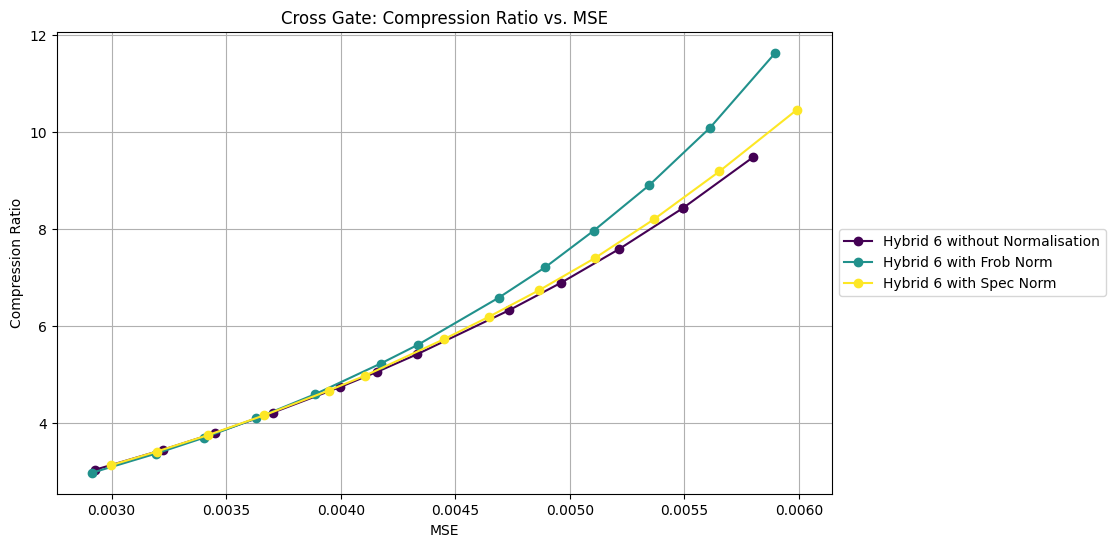

In [197]:
# Baseline memory footprint
baseline_mem_footprint = 3211264

mse_lists = [W4_mses, W7_mses, W10_mses]
label_list = ['Hybrid 6 without Normalisation','Hybrid 6 with Frob Norm', 'Hybrid 6 with Spec Norm']

# Normalizing the memory footprints by the baseline
normalized_W1_mem_footprints = [baseline_mem_footprint/x for x in W4_memory_footprints]
normalized_W2_mem_footprints = [baseline_mem_footprint/x for x in W7_memory_footprints]
normalized_W3_mem_footprints = [baseline_mem_footprint/x for x in W10_memory_footprints]

# Gathering all normalized memory footprints and MSEs
normalized_mem_footprints = [normalized_W1_mem_footprints, normalized_W2_mem_footprints, normalized_W3_mem_footprints]

# Number of different plots
num_plots = len(normalized_mem_footprints)

# Get the Viridis colormap
colors = cm.viridis(np.linspace(0, 1, num_plots))

# Plotting
plt.figure(figsize=(10, 6))
for i, (mem_footprints, mse_list) in enumerate(zip(normalized_mem_footprints, mse_lists)):
    plt.plot(mse_list, mem_footprints, color=colors[i], marker='o', label=f'{label_list[i]}', linestyle='-')

plt.xlabel('MSE')
plt.ylabel('Compression Ratio')
plt.title('Cross Gate: Compression Ratio vs. MSE')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(True)

plt.show()

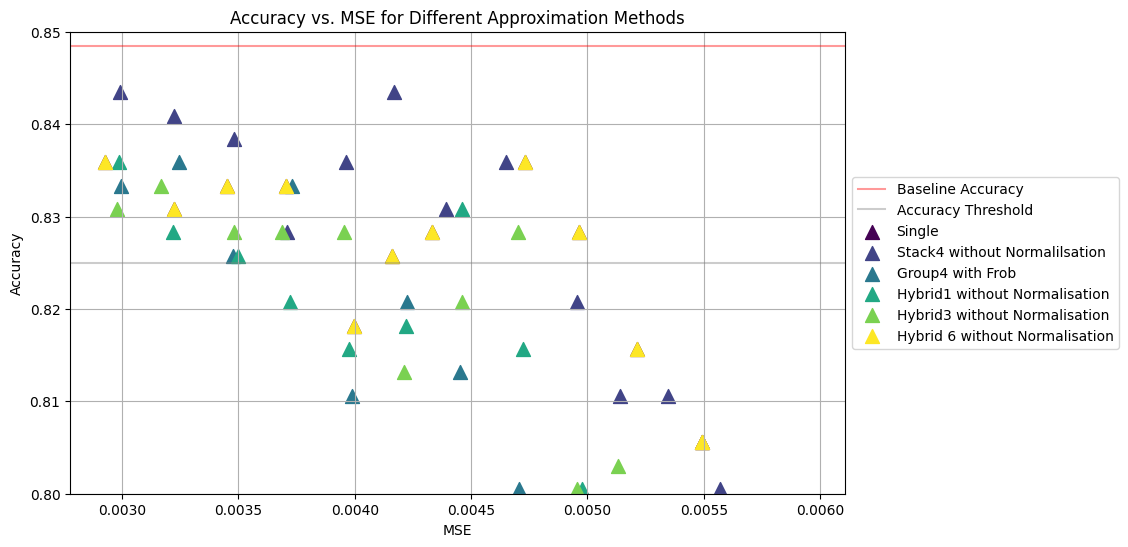

In [216]:
mse_lists = [Single_W1_mses, Stack4_W1_mses,Group4_W2_mses,W1_mses, W2_mses,W4_mses]
accuracy_results = [Single_accuracy_result1, Stack4_accuracy_result1, Group4_accuracy_result2, accuracy_result1, accuracy_result2, accuracy_result4]
label_list = ['Single','Stack4 without Normalilsation','Group4 with Frob','Hybrid1 without Normalisation','Hybrid3 without Normalisation','Hybrid 6 without Normalisation']


# Number of different plots
num_plots = len(accuracy_results)

# Get the Viridis colormap
colors = cm.viridis(np.linspace(0, 1, num_plots))

# Plotting
plt.figure(figsize=(10, 6))
plt.axhline(y=accuracy_baseline, color='r', alpha = 0.4, label='Baseline Accuracy')
plt.axhline(y=0.825, color='gray', alpha = 0.4, label='Accuracy Threshold')

for i, (mse_list, accuracy_result) in enumerate(zip(mse_lists, accuracy_results)):
    plt.scatter(mse_list, accuracy_result, color=colors[i], marker='^', s=100,label=f'{label_list[i]}')

plt.xlabel('MSE')
plt.ylabel('Accuracy')
plt.ylim([0.8,0.85])
plt.title('Accuracy vs. MSE for Different Approximation Methods')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(True)
plt.show()

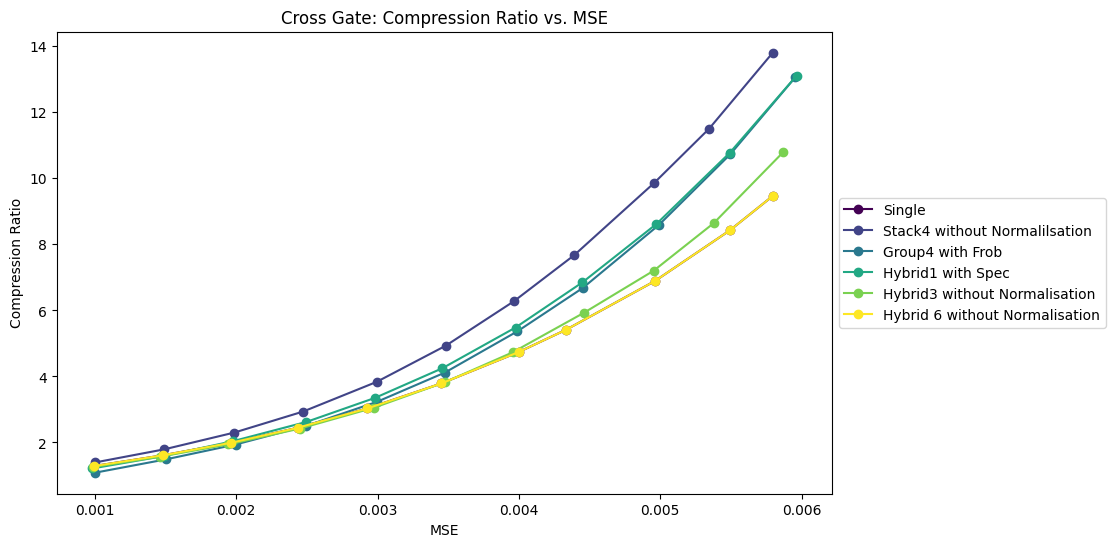

In [177]:
# Baseline memory footprint
baseline_mem_footprint = 3211264

mse_lists = [Single_W1_mses, Stack4_W1_mses,Group4_W2_mses,W8_mses, W2_mses,W4_mses]
accuracy_results = [Single_accuracy_result1, Stack4_accuracy_result1, Group4_accuracy_result2, accuracy_result8, accuracy_result2, accuracy_result4]
label_list = ['Single','Stack4 without Normalilsation','Group4 with Frob','Hybrid1 with Spec','Hybrid3 without Normalisation','Hybrid 6 without Normalisation']

# Normalizing the memory footprints by the baseline
normalized_W1_mem_footprints = [baseline_mem_footprint/x for x in Single_W1_memory_footprints]
normalized_W2_mem_footprints = [baseline_mem_footprint/x for x in Stack4_W1_memory_footprints]
normalized_W3_mem_footprints = [baseline_mem_footprint/x for x in Group4_W2_memory_footprints]
normalized_W4_mem_footprints = [baseline_mem_footprint/x for x in W8_memory_footprints]
normalized_W5_mem_footprints = [baseline_mem_footprint/x for x in W2_memory_footprints]
normalized_W6_mem_footprints = [baseline_mem_footprint/x for x in W4_memory_footprints]

# Gathering all normalized memory footprints and MSEs
normalized_mem_footprints = [normalized_W1_mem_footprints, normalized_W2_mem_footprints, normalized_W3_mem_footprints,normalized_W4_mem_footprints, normalized_W5_mem_footprints,normalized_W6_mem_footprints]

# Number of different plots
num_plots = len(normalized_mem_footprints)

# Get the Viridis colormap
colors = cm.viridis(np.linspace(0, 1, num_plots))

# Plotting
plt.figure(figsize=(10, 6))
for i, (mem_footprints, mse_list) in enumerate(zip(normalized_mem_footprints, mse_lists)):
    plt.plot(mse_list, mem_footprints, color=colors[i], marker='o', label=f'{label_list[i]}', linestyle='-')

plt.xlabel('MSE')
plt.ylabel('Compression Ratio')
plt.title('Cross Gate: Compression Ratio vs. MSE')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()